## Preference learning

In Preference learning, the goal is to learn the user preference based on preference observations. In the view of supervised learning, preference learning trains on a set of items which have preferences toward labels or other items and predicts the preferences for all items.

For instance, consider the wine dataset which, for each wine, reports the quality and characteristics of a set of wines.
Evaluating the quality ( an integer number between 0 and 10) of a bottle of red wine can be very hard for a non-Specialist. Instead, for a non-Specialist, it can be easier to simply give preferences:
* wine A $\succ$ wine B
* wine A  $\succ$ wine C
* wine E  $\succ$ wine F
* ...

where  $\succ$ means "preferred to", by listing preferences. Therefore, the user is giving preferences toward the characteristics of the wines:

* the wine with characteristic [7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4] is better than
the wine with characteristics [5.2,1.7,0,2.9,0.76,8,34,0.6978,3.51,2.56,5.8] where these numbers are fixed acidity,	volatile acidity,	citric acid,	residual sugar,	chlorides,	free sulfur dioxide,	total sulfur dioxide,	density,	pH,	sulphates,	alcohol, see https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009

We assume that these preferences can be noisy, because the user can make mistakes.

Our goal is to derive a probabilistic model to learn user preferences and make predictions.
This is very useful in recommendation systems, we may for instance want to suggest the user to buy a certain wine because we "believe" they are going to like it.

Before considering a more complex example like the wine dataset, we will focus on a 1D simulated dataset.

Give a nonlinear function, in the example $f(x)=-25 x^2+30 x^5$, and input points $x_i,x_j$, we will generate  preferences as follows:

$$
\begin{array}{ll}
x_i \succ x_j  \text{ if } f(x_i)>f(x_j)\\
x_j \succ x_i  \text{ if } f(x_j)>f(x_i)\\
\end{array}
$$

we will also add some Gaussian noise (with zero mean and standard deviation $0.1$) to the function $f$ to simulate that the preference $\succ $ may be noisy.

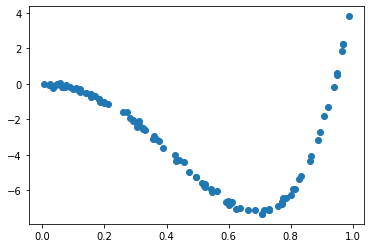

In [256]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats as stat

def f(x):
    return -25*x**2+30*x**5+np.random.randn(len(x))*0.1 
#np.random.randn(len(x))*0.1 is equivalent to st.norm(0,0.1).rvs(len(x)) in scipy stats
np.random.seed(42)
x=np.sort(np.random.rand(100))
plt.scatter(x,f(x))

In [257]:
np.random.seed(1)
def pairwise_preferences(m,x,f):
    Pref=[]
    W=[]
    for i in range(m):
        w=np.zeros(len(x))
        i1 = np.random.randint(len(x))
        i2 = np.random.randint(len(x))
        if i1!=i2:
            if f(x[[i1]])>f(x[[i2]]):
                Pref.append([i1,i2])# x[i1] is preferred to x[i2]
                w[i1]=1
                w[i2]=-1
            else:
                Pref.append([i2,i1])# x[i2] is preferred to x[i1]
                w[i1]=-1
                w[i2]=1
            W.append(w)
    return  np.unique(np.vstack(W),axis=0),np.unique(np.vstack(Pref),axis=0)
            
m=50
W_train,Pref_train= pairwise_preferences(m,x,f)            
print(Pref_train[0:5,:])
m=100
W_test,Pref_test= pairwise_preferences(m,x,f)               

[[ 0 54]
 [ 0 60]
 [ 0 77]
 [ 3 56]
 [ 6 25]]


Your **task** is to use the dataset $ D=\{x,Pref\}$ to predict a preference, for instance 

> Is the point $0.8$ preferred to $0.6$ ?

To do that we need to estimate from the data the so called "preference function", a function that determines the preference. In the example, this function is $f(x)=-25 x^2+30 x^5$, but we do not know it. We only know the dataset  $ D=\{x,Pref\}$.

We will build a probabilistic model to do that. Given the function $f$ we know that 


$$
\begin{array}{ll}
x_i \succ x_j  \text{ if } f(x_i)>f(x_j)\\
\end{array}
$$

This is a sort of censored observation: we know that $f(x_j) < f(x_i) < \infty$ and, therefore, we can use the same likelihood model we already know

$$
p(x_i \succ x_j|f,\sigma)=\Phi\left(\frac{f(x_i)-f(x_j)}{\sigma},0,1\right)
$$

where $\Phi$ is the CDF of the Gaussian distribution (zero mean and standard deviation 1) computed at $\frac{f(x_i)-f(x_j)}{\sigma}$.

However, we do not know $f$ and we want to use the data to estimate $f$. We can use a polynomial function to approximate $f$:

$$
f(x) \approx \alpha + \beta_1 x + \beta_2 x^2+ \beta_3 x^3
$$

Note that I selected the degree $3$ because I am assuming we do not know the true function $f$ (which is actually a degree 5 polynomial).



This is the probabilistic model

**Likelihood**

$$
p(x_i \succ x_j|f,\sigma)=\Phi\left(\frac{f(x_i)-f(x_j)}{\sigma},0,1\right)
$$
with $f(x) = \alpha + \beta_1 x + \beta_2 x^2+ \beta_3 x^3$. Therefore, assuming the observations are independent

$$
p(Data|\alpha,\beta_i,\sigma)=\prod_{i,j \in Pref}\Phi\left(\frac{f(x_i)-f(x_j)}{\sigma},0,1\right)
$$

Note that 
$$
f(x_i)-f(x_j)=\beta_1 (x_i-x_j) + \beta_2 (x_i^2-x_j^2)+ \beta_3 (x_i^3-x_j^3)
$$
and, therefore, it does not depend on $\alpha$. Therefore, we do not need the intercept.

**Prior**
$$
~p(\beta_i)=N(\beta_i,0,20), ~~p(\sigma)=\text{Uniform}(\sigma,0.0001,10)
$$

**Posterior** 
You have to use PyMC3 to sample from the posterior define by the above model, that is

$$
\underbrace{p(\beta_1,\beta_2,\beta_3,\sigma|\text{data})}_{\text{posterior}} = \frac{\underbrace{\prod_{i,j \in Pref}\Phi\left(\frac{\beta_1 (x_i-x_j) + \beta_2 (x_i^2-x_j^2)+ \beta_3 (x_i^3-x_j^3)}{\sigma},0,1\right)}_{\text{likelihood}}\underbrace{\prod_{i=1}^3 N(\beta_i,0,20)\text{Uniform}(\sigma,0.001,10)}_{\text{prior}}}{\underbrace{p(\text{data})}_{\text{evidence}}}
$$

Hereafter the PyMC3 code that implements the above model.

In [258]:
import theano.tensor as tt
import pymc3 as pm

x_n = x.copy()

X=np.hstack([x_n.reshape(-1,1),x_n.reshape(-1,1)**2,x_n.reshape(-1,1)**3])#polynomial features
y=np.ones(W_train.shape[0])#number of preferences
mymodel=pm.Model()
with mymodel:
    beta  = pm.Normal('beta', 0.0,20, shape=(X.shape[1],))#shape=4 because there are three beta parameters
    sigma = pm.Uniform('sigma',0.001,10)
    mu=pm.math.dot(W_train,pm.math.dot(X,beta))
    Phi = pm.Deterministic('Phi',  0.5*(1+tt.erf(mu/sigma/np.sqrt(2)))+1e-100)#CDF Normal 
    #tt.printing.Print('alpha_ls')(phi)
    likelihood = pm.Bernoulli('likelihood', Phi, observed=y)
    #l1=pm.DensityDist('Like',custom_dist_logp,observed=dict(beta=beta, sigma=sigma, x=x, Pref=Pref))

with mymodel:
    approx = pm.fit(30000,method='advi')# fullrank_advi')#'fullrank_advi'

Average Loss = 35.52: 100%|██████████| 30000/30000 [00:07<00:00, 4048.25it/s] 
Finished [100%]: Average Loss = 35.499


Note that we have added the epsilon 1e-100 to avoid numerical problems with zero probabilities. 
The array $y$ is used to account for the way the Bernoulli distribution is defined:

$$
\Phi^{y}(1-\Phi)^{1-y}
$$

in our model we have only the term $\phi$ and, therefore, we have defined this dummy class variable $y$ (that includes only ones) to build the likelihood:


$$
p(Data|\alpha,\beta_i,\sigma)=\prod_{i,j \in Pref}\Phi\left(\frac{f(x_i)-f(x_j)}{\sigma},0,1\right)
$$



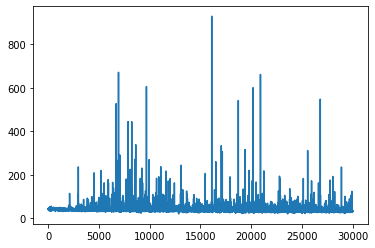

In [259]:
plt.plot(approx.hist);

In [260]:
#we sample from the posterior
posterior=approx.sample(10000)

### Plotting the latent function
We can plot the latent function learned from the preferences.

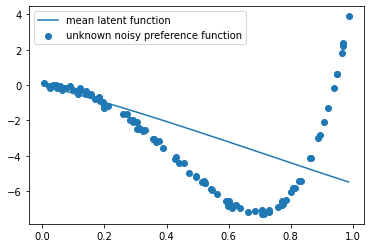

In [261]:
beta_est=np.mean(posterior['beta'],axis=0)#mean beta parameters
plt.plot(x,X.dot(beta_est),label='mean latent function')
plt.scatter(x,f(x),label='unknown noisy preference function')
plt.legend()

We can visualise the uncertainty

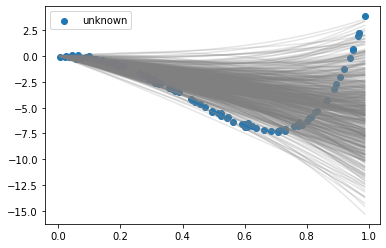

In [262]:
plt.plot(x,X.dot(posterior['beta'].T[:,0:500]),color='gray',alpha=0.2)
plt.scatter(x,f(x),label='unknown')
plt.legend()

Note that all the lines go through zero. This happens because the polynomial 

$$
\beta_1 x+\beta_2 x^2+\beta_3 x^3
$$

is always zero at $x=0$ no matter the value of $\beta_i$. 

### Accuracy
We now can predict the preferences of the user on the test points. `W` includes the preference of the users for the pairs in `Pref`.
For the way we defined  `W`, our model predicts correctly the user preferences if the vector

$$
\Phi(W X\beta)
$$

is greater than $0.5$ for all the elements.

In [263]:
#compute posterior probabilities
prob=0.5*(1+erf(np.dot(W_train,X.dot(posterior['beta'].T))/posterior['sigma']/np.sqrt(2)))
Predict_probability=np.mean(prob,axis=1)#mean posterior probability
Accuracy=np.sum(Predict_probability>0.5)/W_train.shape[0]
print("Accuracy training=",Accuracy)

Accuracy training= 0.76


The accuracy is quite low, can it be due to the choice of the model for the latent function

$f(x) = \beta_1 x + \beta_2 x^2+ \beta_3 x^3$

that is a degree 3 polynomial?

In [264]:
#compute posterior probabilities
prob=0.5*(1+erf(np.dot(W_train,X.dot(posterior['beta'].T))/posterior['sigma']/np.sqrt(2)))
Predict_probability=np.mean(prob,axis=1)#mean posterior probability
Accuracy=np.sum(Predict_probability>0.5)/W_train.shape[0]
print("Accuracy training=",Accuracy)

prob=0.5*(1+erf(np.dot(W_test,X.dot(posterior['beta'].T))/posterior['sigma']/np.sqrt(2)))
Predict_probability=np.mean(prob,axis=1)
Accuracy=np.sum(Predict_probability>0.5)/W_test.shape[0]
print("Accuracy testing=",Accuracy)

Accuracy training= 0.76
Accuracy testing= 0.696969696969697


### Increasing the degree of the polynomial


In [265]:
import theano.tensor as tt
import pymc3 as pm


deg=6
X=x_n.reshape(-1,1)
for i in range(1,deg+1):
    X=np.hstack([X,x_n.reshape(-1,1)**i])#polynomial features
y=np.ones(W_train.shape[0])#number of preferences
mymodel=pm.Model()
with mymodel:
    beta  = pm.Normal('beta', 0.0,20, shape=(X.shape[1],),testval=np.random.randn(X.shape[1]))#shape=4 because there are three beta parameters
    sigma = pm.Uniform('sigma',0.001,10)
    mu=pm.math.dot(W_train,pm.math.dot(X,beta))
    phi = pm.Deterministic('phi',  0.5*(1+tt.erf(mu/sigma/np.sqrt(2)))+1e-100)#CDF Normal 
    #tt.printing.Print('alpha_ls')(phi)
    likelihood = pm.Bernoulli('likelihood', phi, observed=y)
    #l1=pm.DensityDist('Like',custom_dist_logp,observed=dict(beta=beta, sigma=sigma, x=x, Pref=Pref))

with mymodel:
    approx = pm.fit(70000,method='advi')# fullrank_advi')#'fullrank_advi'

Average Loss = 30.308: 100%|██████████| 70000/70000 [00:17<00:00, 4099.29it/s]
Finished [100%]: Average Loss = 30.321


Accuracy training= 0.98
Accuracy testing= 0.9191919191919192


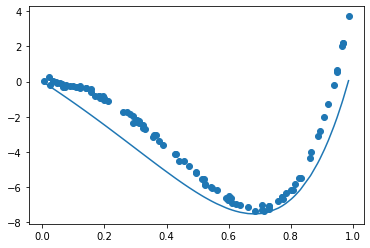

In [266]:
#we sample from the posterior
posterior=approx.sample(5000)

beta_est=np.mean(posterior['beta'],axis=0)
plt.plot(x,X.dot(beta_est))
plt.scatter(x,f(x))
#plt.ylim([-4,3])

prob=0.5*(1+erf(np.dot(W_train,X.dot(posterior['beta'].T))/posterior['sigma']/np.sqrt(2)))
Predict_probability=np.mean(prob,axis=1)
Accuracy=np.sum(Predict_probability>0.5)/W_train.shape[0]
print("Accuracy training=",Accuracy)

prob=0.5*(1+erf(np.dot(W_test,X.dot(posterior['beta'].T))/posterior['sigma']/np.sqrt(2)))
Predict_probability=np.mean(prob,axis=1)
Accuracy=np.sum(Predict_probability>0.5)/W_test.shape[0]
print("Accuracy testing=",Accuracy)

Note that, the blue line does not have to go through the points but only to model the same type of preference.

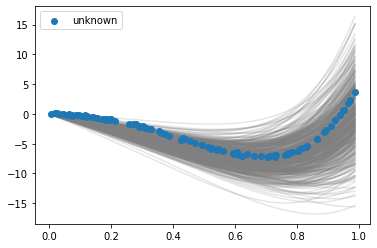

In [270]:
plt.plot(x,X.dot(posterior['beta'].T[:,0:500]),color='gray',alpha=0.2)
plt.scatter(x,f(x),label='unknown',Zorder=1000)
plt.legend()

Let's increase the degree even more

In [271]:

deg=15
X=x_n.reshape(-1,1)
for i in range(1,deg+1):
    X=np.hstack([X,x_n.reshape(-1,1)**i])#polynomial features
y=np.ones(W_train.shape[0])#number of preferences
mymodel=pm.Model()
with mymodel:
    beta  = pm.Normal('beta', 0.0,20, shape=(X.shape[1],),testval=np.random.randn(X.shape[1]))#shape=4 because there are three beta parameters
    sigma = pm.Uniform('sigma',0.001,10)
    mu=pm.math.dot(W_train,pm.math.dot(X,beta))
    phi = pm.Deterministic('phi',  0.5*(1+tt.erf(mu/sigma/np.sqrt(2)))+1e-100)#CDF Normal 
    #tt.printing.Print('alpha_ls')(phi)
    likelihood = pm.Bernoulli('likelihood', phi, observed=y)
    #l1=pm.DensityDist('Like',custom_dist_logp,observed=dict(beta=beta, sigma=sigma, x=x, Pref=Pref))

with mymodel:
    approx = pm.fit(70000,method='advi')# fullrank_advi')#'fullrank_advi'

Average Loss = 35.621: 100%|██████████| 70000/70000 [00:18<00:00, 3866.15it/s]
Finished [100%]: Average Loss = 35.577


Accuracy training= 0.94
Accuracy testing= 0.9696969696969697


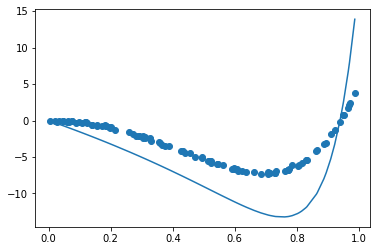

In [272]:
#we sample from the posterior
posterior=approx.sample(10000)

beta_est=np.mean(posterior['beta'],axis=0)
plt.plot(x,X.dot(beta_est))
plt.scatter(x,f(x))
#plt.ylim([-4,3])

prob=0.5*(1+erf(np.dot(W_train,X.dot(posterior['beta'].T))/posterior['sigma']/np.sqrt(2)))
Predict_probability=np.mean(prob,axis=1)
Accuracy=np.sum(Predict_probability>0.5)/W_train.shape[0]
print("Accuracy training=",Accuracy)

prob=0.5*(1+erf(np.dot(W_test,X.dot(posterior['beta'].T))/posterior['sigma']/np.sqrt(2)))
Predict_probability=np.mean(prob,axis=1)
Accuracy=np.sum(Predict_probability>0.5)/W_test.shape[0]
print("Accuracy testing=",Accuracy)

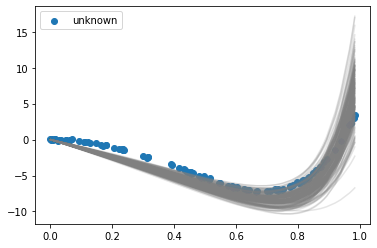

In [242]:
plt.plot(x,X.dot(posterior['beta'].T[:,0:200]),color='gray',alpha=0.2)
plt.scatter(x,f(x),label='unknown')
plt.legend()

## Limits of this approach

We need a very large degree to model preferences that are particularly nonlinear. A way to improve this model is to move to Neural Networks or nonparametric models.